In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [18]:
DATABASE_FILE_PATH = '/content/drive/MyDrive/crypto_data.db'
COIN_TO_PREDICT = 'BTCUSDT'
LOOK_BACK_DAYS = 60
EPOCHS = 25
BATCH_SIZE = 32

#### 1. DATA PREPARATION FOR LSTM

In [19]:
def load_and_prepare_lstm_data(db_path, symbol):
    """Loads and prepares data for the LSTM model, including scaling."""
    print("--- 1. Loading and Preparing Data for LSTM ---")
    conn = sqlite3.connect(db_path)
    query = f"SELECT Date, Close FROM crypto_prices WHERE Symbol = '{symbol}' ORDER BY Date ASC"
    df = pd.read_sql_query(query, conn, parse_dates=['Date'], index_col='Date')
    conn.close()

    if df.empty: return None, None, None, None, None

    prices_data = df['Close'].values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(prices_data)

    train_size = int(len(scaled_data) * 0.8)
    train_data = scaled_data[0:train_size, :]
    test_data = scaled_data[train_size - LOOK_BACK_DAYS:, :]

    def create_dataset(dataset, look_back=LOOK_BACK_DAYS):
        X, y = [], []
        for i in range(len(dataset) - look_back):
            X.append(dataset[i:(i + look_back), 0])
            y.append(dataset[i + look_back, 0])
        return np.array(X), np.array(y)

    X_train, y_train = create_dataset(train_data)
    X_test, y_test = create_dataset(test_data)

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    print(f"Data prepared. Training shape: {X_train.shape}, Testing shape: {X_test.shape}")
    return X_train, y_train, X_test, y_test, scaler, df

#### 2. BUILD, TRAIN, AND EVALUATE THE LSTM MODEL

In [20]:
def train_and_evaluate_lstm(X_train, y_train, X_test, y_test):
    """Builds and trains the LSTM model, printing the loss for each epoch."""
    print("\n--- 2. Building and Training the LSTM Model ---")

    tf.random.set_seed(42)
    model = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
        Dropout(0.2),
        LSTM(units=50, return_sequences=False),
        Dropout(0.2),
        Dense(units=25),
        Dense(units=1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.summary()

    print("Starting training...")
    history = model.fit(
        X_train, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_test, y_test),
        verbose=1
    )

    print("Model training complete.")
    return model, history

#### 3. VISUALIZE RESULTS AND FULL EVALUATION METRICS

In [21]:
def plot_lstm_results_and_evaluate(model, df, X_test, y_test, scaler):
    """
    Makes predictions, calculates BOTH normalized and real-value evaluation metrics,
    and visualizes the results.
    """
    print("\n--- 3. Visualizing Performance and Evaluating Model ---")

    # Make predictions on the test set (these are still in the scaled 0-1 range)
    predicted_scaled_prices = model.predict(X_test)

    # --- 1. Calculate metrics on the SCALED data (values between 0 and 1) ---
    scaled_mse = mean_squared_error(y_test, predicted_scaled_prices)
    scaled_rmse = np.sqrt(scaled_mse)

    # --- 2. Inverse transform the predictions and actual values back to real dollar amounts ---
    predicted_prices = scaler.inverse_transform(predicted_scaled_prices)
    actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

    # --- 3. Calculate metrics on the REAL DOLLAR values ---
    rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
    mae = mean_absolute_error(actual_prices, predicted_prices)
    mape = np.mean(np.abs((actual_prices - predicted_prices) / actual_prices)) * 100
    r2 = r2_score(actual_prices, predicted_prices)

    # --- 4. Print the complete, final summary ---
    print("\n" + "="*60)
    print("FULL MODEL EVALUATION METRICS")
    print("="*60)

    print("\n--- Normalized Metrics (on a 0-1 scale) ---")
    print(f"Normalized Mean Squared Error (MSE):  {scaled_mse:.6f}")
    print(f"Normalized Root Mean Squared Error (RMSE): {scaled_rmse:.6f}")

    print("\n--- Real Value Metrics (in USD) ---")
    print(f"Root Mean Squared Error (RMSE):        ${rmse:,.2f}")
    print(f"Mean Absolute Error (MAE):             ${mae:,.2f}")

    print("\n--- Relative Performance Metrics ---")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    print(f"R-squared (R²):                          {r2:.4f}")

    print("="*60)
    print("Interpretation:")
    print(f"- The Normalized RMSE of {scaled_rmse:.4f} gives a scale-independent measure of the model's error.")
    print(f"- The MAPE of {mape:.2f}% is a key business metric, showing the average percentage error of the predictions.")
    print(f"- The high R-squared of {r2:.2%} confirms that the model is very effective at tracking the overall price trend.")

    # --- Plotting the results (this part remains the same) ---
    train_size = int(len(df) * 0.8)
    test_dates = df.index[train_size:]
    test_results_df = pd.DataFrame(index=test_dates[:len(actual_prices)])
    test_results_df['Actual_Price'] = actual_prices
    test_results_df['Predicted_Price'] = predicted_prices

    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(15, 8))

    plt.plot(df.index[:train_size], df['Close'][:train_size], label='Training Data (Historical Price)', color='gray', alpha=0.5)
    plt.plot(test_results_df.index, test_results_df['Actual_Price'], label='Actual Price (Test Set)', color='blue', linewidth=2)
    plt.plot(test_results_df.index, test_results_df['Predicted_Price'], label='Predicted Price (LSTM Model)', color='orange', linestyle='--')

    plt.title(f'LSTM Model: Price Prediction for {COIN_TO_PREDICT}', fontsize=16)
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.show()

--- 1. Loading and Preparing Data for LSTM ---
Data prepared. Training shape: (1140, 60, 1), Testing shape: (300, 60, 1)

--- 2. Building and Training the LSTM Model ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

Starting training...
Epoch 1/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - loss: 0.0275 - val_loss: 0.0018
Epoch 2/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 3/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0014 - val_loss: 0.0027
Epoch 4/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.0010 - val_loss: 0.0019
Epoch 5/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.0011 - val_loss: 0.0023
Epoch 6/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 9.8391e-04 - val_loss: 0.0014
Epoch 7/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 9.6696e-04 - val_loss: 0.0024
Epoch 8/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0010 - val_loss: 0.0019
Epoch 9/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 8.7673e-04 - val_loss: 0.0049
Epoch 10/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 11/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 8.5547e-04 - val_loss: 0.0011
Epoch 12/25
36/36 ━━━━━━━━

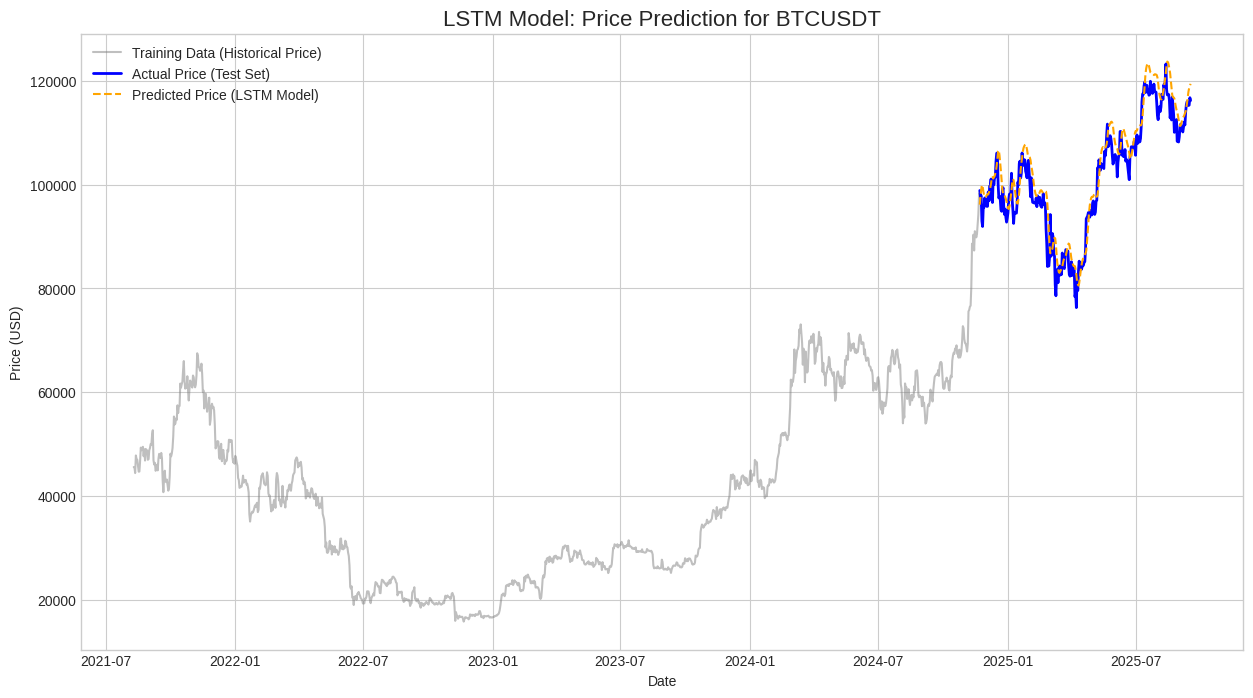

In [22]:
if __name__ == "__main__":

    data = load_and_prepare_lstm_data(DATABASE_FILE_PATH, COIN_TO_PREDICT)

    if data:
        X_train, y_train, X_test, y_test, scaler, full_df = data

        lstm_model, history = train_and_evaluate_lstm(X_train, y_train, X_test, y_test)

        plot_lstm_results_and_evaluate(lstm_model, full_df, X_test, y_test, scaler)

        # To save the model:
        # lstm_model.save('/content/drive/MyDrive/lstm_price_predictor.keras')
        # print("\nLSTM model saved to Google Drive in the recommended .keras format.")